In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
blacklist = ["career", "opportunity", "work", "team", "mention", "experience", "knowledge", "skill", "ability", "company", "date", "qualification", "website", "open", "develop",
             "title", "excellent", "position", "email", "letter", "language", "post", "english", "center", "title", "salary","follow", "thank", "job", "good", "time", "great", "project", "required", "year", "month", "day",
             "form"]

def clean_text(text):
    # Remove URLs and anything starting with http or www
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    
    # Lowercase the text
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove multiple whitespaces
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token.strip() for token in tokens if token not in stop_words]

    # Remove single-character tokens and blacklist words
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2 and not any([x in token for x in blacklist])]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Change '-ing' verbs to root form
    final_tokens = [lemmatizer.lemmatize(token[:-3], pos='v') if token.endswith('ing') and lemmatizer.lemmatize(token, pos='v') != token else token for token in lemmatized_tokens]
    
    # Join the tokens back into a string
    cleaned_text = ' '.join(final_tokens)
    
    return cleaned_text

In [4]:
df = pd.read_csv('jobs.csv')
df.dropna(subset=["job_desc"], inplace=True)
df["tokens"] = df["job_desc"].apply(clean_text)
df.rename(columns={"job_desc": "text"}, inplace=True)
df = df[["text", "tokens"]]
df.dropna(subset=["tokens"], inplace=True)
df

,text,tokens
0,About the job\nCH Wireline Operator (inclusive...,wireline operator inclusive junior senior lead...
1,About the job\nDescription\n\nUnder the superv...,description supervision advanced emergency dep...
2,About the job\nPosition: Pelvic Health Physica...,pelvic health physical therapist location bend...
3,About the job\nWho We Are?\nEastland Food has ...,eastland food become recognized come responsib...
4,About the job\nJob Description\n\nPart-Time\n\...,description part make big money menards extra ...
...,...,...
609,About the job\nPosition Title: Day to day Secr...,secretary department build report build princi...
610,About the job\n\nSummary\n\nApple is seeking a...,summary apple seek enthusiastic leader direct ...
611,"About the job\nAt Chanel, we are focused on cr...",chanel focused creat inclusive culture nurture...
612,About the job\nWhen you join the growing BILH ...,join grow bilh tak mak difference people life ...


In [5]:
from googletrans import Translator
translator = Translator()

def translate_wrap(x):
    try:
        return translator.translate(x, dest="en").text
    except:
        return x

resumes = pd.read_csv("resumes.csv")
resumes.rename(columns={"Compétences": "skills", "Expérience": "exp"}, inplace=True)
resumes["text"] = resumes["skills"] + resumes["exp"]
resumes.dropna(subset=["text"], inplace=True)
resumes.text = resumes.text.apply(translate_wrap)
resumes.dropna(subset=["text"], inplace=True)
resumes["tokens"] = resumes.text.apply(clean_text)
resumes.dropna(subset=["tokens"], inplace=True)
resumes = resumes[["text", "tokens"]]
df = pd.concat([df, resumes], join="inner", axis=0)
df

,text,tokens
0,Competes and my knowledge of handling E Apprie...,competes handl professional carr efour technic...
1,SEO Team Team TEAM TEAM WORK ECOMERCE OPTIMITI...,seo ecomerce optimition window microsoft googl...
2,Technical skills CRM *Oracle JDE *GPAO Program...,technical crm oracle jde gpao programm tool py...
3,Professional technique skills Professional Con...,professional technique professional configure ...
7,Compertencesexperiennes Professional Contact A...,compertencesexperiennes professional contact a...
...,...,...
95,Hardware Techniques Competitions Maintenance a...,hardware technique competition maintenance rep...
98,Energic professional skills and endowed with a...,energic professional endowed solid spirit leco...
99,competences conception et developpement de so...,competence conception solu tions inteligence a...
104,Competes Social media Facebook Instagram Skype...,competes social medium facebook instagram skyp...


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             evaluate_every= 1,
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(df.tokens)

In [21]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [23]:
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -297053.05341733794
Model Perplexity:  1288.3685530179082


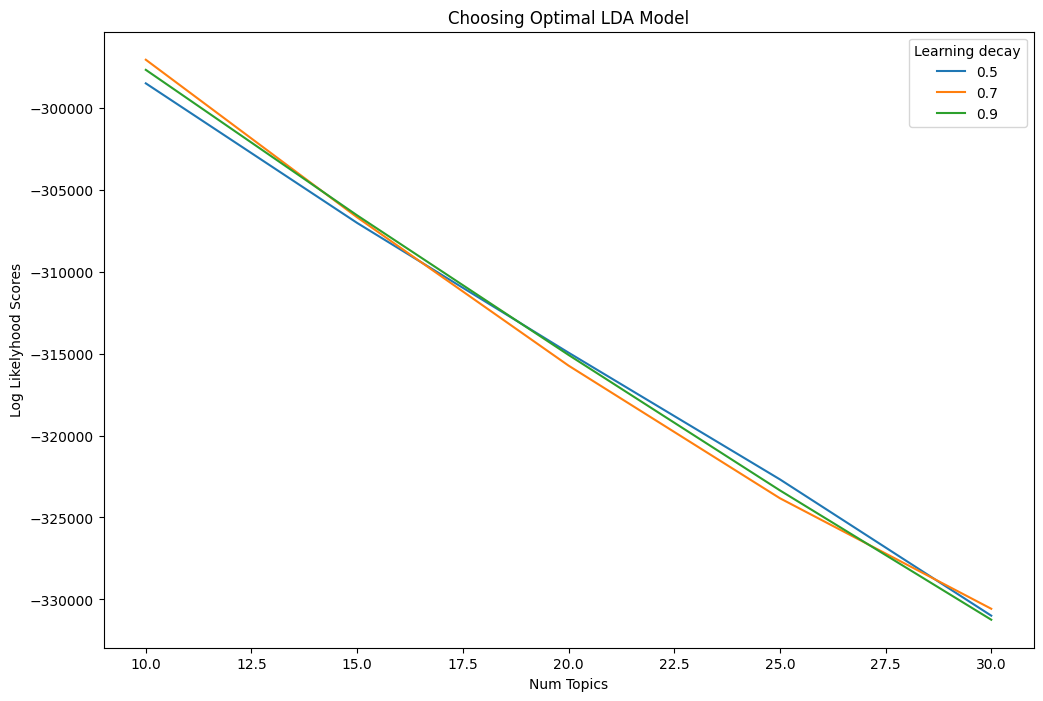

In [52]:
# Get Log Likelyhoods from Grid Search Output
import matplotlib.pyplot as plt
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(x) for x in model.cv_results_["mean_test_score"][:5]]
log_likelyhoods_7 = [round(x) for x in model.cv_results_["mean_test_score"][5:10]]
log_likelyhoods_9 = [round(x) for x in model.cv_results_["mean_test_score"][10:]]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [48]:
model.cv_results_["mean_test_score"]

array([-298495.3463995 , -307017.9283003 , -314935.86292462,
       -322672.14609004, -330992.52584899, -297053.05341734,
       -306674.88991396, -315727.39759592, -323824.35111502,
       -330571.91686723, -297670.84094985, -306556.23352922,
       -315074.6494031 , -323344.26800077, -331240.61154643])

In [26]:
test_job = """Job Title: Machine Learning Engineer

Job Description:

Our company is looking for a highly skilled Machine Learning Engineer to join our team. As a Machine Learning Engineer, you will be responsible for developing and implementing cutting-edge machine learning models and algorithms that will power our products and services.

Responsibilities:

Design, develop and deploy scalable and efficient machine learning models and algorithms to solve complex business problems
Collaborate with cross-functional teams to gather and analyze data, identify key insights, and develop solutions that meet business requirements
Conduct research to stay up-to-date with the latest advancements in machine learning and data science
Implement data pre-processing, feature engineering, and model selection techniques to optimize performance of machine learning models
Deploy machine learning models to production environments and monitor their performance in real-time
Develop tools and systems to automate data collection, cleaning, and analysis processes
Requirements:

Bachelor's or Master's degree in Computer Science, Data Science, Mathematics, Statistics, or related field
At least 3 years of experience in developing and deploying machine learning models and algorithms in a production environment
Strong programming skills in Python and proficiency in machine learning libraries such as TensorFlow, Keras, and PyTorch
Experience with data pre-processing, feature engineering, and model selection techniques
Solid understanding of statistics, linear algebra, and probability theory
Experience with cloud-based machine learning platforms such as AWS, Azure, or GCP is a plus
Strong problem-solving skills, ability to work independently and as part of a team, and excellent communication skills.
If you are passionate about machine learning and want to work on cutting-edge technology to solve real-world problems, then we encourage you to apply for this exciting opportunity."""

test_resume = """
Name: John Doe
Email: johndoe@email.com
Phone: 555-555-5555
Location: Anytown, USA

Summary:
I am a skilled Machine Learning Engineer with over 5 years of experience in designing and implementing machine learning algorithms and models. My expertise lies in developing scalable and efficient solutions for complex data problems. I am proficient in various programming languages, such as Python and R, and have hands-on experience with popular machine learning frameworks, including TensorFlow and PyTorch. I am dedicated to staying updated with the latest advancements in the field and continually expanding my knowledge and skills.

Skills:
- Strong proficiency in machine learning algorithms and techniques.
- Experience with Python and R programming languages.
- Proficiency in machine learning frameworks such as TensorFlow and PyTorch.
- Data preprocessing, feature engineering, and model evaluation.
- Deep learning architectures and neural networks.
- Experience with cloud platforms, such as AWS or GCP, for scalable machine learning deployments.
- Strong problem-solving and analytical skills.
- Excellent communication and collaboration abilities.
- Bachelor's degree in Computer Science, Data Science, or a related field.

Experience:
Machine Learning Engineer
ABC Technology Solutions, Anytown, USA
June 2019 - Present

- Developed and implemented machine learning models to solve complex business problems.
- Conducted data preprocessing, feature selection, and feature engineering to enhance model performance.
- Utilized TensorFlow and PyTorch to build and train deep learning models.
- Collaborated with cross-functional teams to identify and define machine learning project requirements.
- Deployed machine learning models in cloud environments for scalable and efficient production use.
- Optimized models for performance and scalability, considering factors such as memory usage and inference time.
- Conducted model evaluation and validation, utilizing appropriate metrics and techniques.
- Stayed updated with the latest research and advancements in machine learning and incorporated them into projects.

Machine Learning Intern
XYZ Research Institute, Anytown, USA
January 2017 - May 2019

- Assisted in developing machine learning algorithms and models for research projects.
- Conducted data analysis, preprocessing, and feature engineering.
- Collaborated with researchers to implement and evaluate machine learning experiments.
- Assisted in the collection and annotation of data for training and testing purposes.
- Conducted literature reviews and stayed informed about recent developments in the field.
- Presented research findings to internal teams and contributed to research papers.

Education:
Bachelor's degree in Computer Science, Data Science, or a related field
Anytown University, Anytown, USA
Year of Graduation: 2016

References:
Available upon request"""

In [27]:
### TESTING
new_text_bow = vectorizer.transform([clean_text(test_job)])
topic_probabilities = best_lda_model.transform(new_text_bow)

# Get the most likely topic and its probability
most_likely_topic = topic_probabilities.argmax()
probability_of_topic = topic_probabilities[0, most_likely_topic]

# Print the result
print(f"The most likely topic for the job is topic {most_likely_topic}, with a probability of {probability_of_topic}")

new_text_bow = vectorizer.transform([clean_text(test_resume)])
topic_probabilities = best_lda_model.transform(new_text_bow)

# Get the most likely topic and its probability
most_likely_topic = topic_probabilities.argmax()
probability_of_topic = topic_probabilities[0, most_likely_topic]

# Print the result
print(f"The most likely topic for the resume is topic {most_likely_topic}, with a probability of {probability_of_topic}")

The most likely topic for the job is topic 3, with a probability of 0.5401251741573313
The most likely topic for the resume is topic 3, with a probability of 0.5242964758534372


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def calculate_similarity(job_description, resume):
    # Create a TF-IDF vectorizer object
    vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit and transform the job description and resume to TF-IDF matrices
    job_description_tfidf = vectorizer.fit_transform([job_description])
    resume_tfidf = vectorizer.transform([resume])
    
    # Calculate the cosine similarity between the two TF-IDF matrices
    cosine_similarity = np.dot(job_description_tfidf.toarray(), resume_tfidf.toarray().T)
    
    # Return the cosine similarity score
    return cosine_similarity[0][0]

calculate_similarity(clean_text(test_job), clean_text(test_resume))

0.23719139812819728